In [1]:
# Required library imports
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,4a16050093a99092,"No, you have to prove that I can't.",0,0,0,0,0,0
1,6bc2122dc27e275a,Re: My major edit summaries \n\nI have receive...,0,0,0,0,0,0
2,5570f7207bade92f,I depersonalized it. It's sad how you don't ob...,0,0,0,0,0,0
3,a17d6408ffb98139,Thats because I was blocked before I could dis...,0,0,0,0,0,0
4,11b1d25d77ffd834,"I apologise for this, I was just angry with ha...",0,0,0,0,0,0


In [4]:
data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111699 entries, 0 to 111698
Data columns (total 8 columns):
id               111699 non-null object
comment_text     111699 non-null object
toxic            111699 non-null int64
severe_toxic     111699 non-null int64
obscene          111699 non-null int64
threat           111699 non-null int64
insult           111699 non-null int64
identity_hate    111699 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.8+ MB


In [6]:
# function to identify comment_text which are clean. 
def clean_comments(row):
    if row['toxic'] == 1:
        return 0
    if row['severe_toxic'] == 1:
        return 0
    if row['obscene'] == 1:
        return 0
    if row['threat'] == 1:
        return 0
    if row['insult'] == 1:
        return 0
    if row['identity_hate'] == 1:
        return 0
    else:
        return 1

In [7]:
# all those comment_text which don't lie in any of the categories
data['Clean'] = data.apply(lambda row : clean_comments(row), axis = 1)

In [8]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Clean
0,4a16050093a99092,"No, you have to prove that I can't.",0,0,0,0,0,0,1
1,6bc2122dc27e275a,Re: My major edit summaries \n\nI have receive...,0,0,0,0,0,0,1
2,5570f7207bade92f,I depersonalized it. It's sad how you don't ob...,0,0,0,0,0,0,1
3,a17d6408ffb98139,Thats because I was blocked before I could dis...,0,0,0,0,0,0,1
4,11b1d25d77ffd834,"I apologise for this, I was just angry with ha...",0,0,0,0,0,0,1


In [9]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

([array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])],
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 6 Lists of Patches objects>)

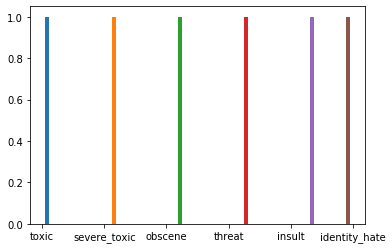

In [10]:
plt.hist(class_names,bins = 10)

In [13]:
corr_matrix = data.corr()

In [17]:
corr_matrix.style.background_gradient(cmap='coolwarm')

,toxic,severe_toxic,obscene,threat,insult,identity_hate,Clean
toxic,1,0.311058,0.675811,0.160783,0.65015,0.268546,-0.96793
severe_toxic,0.311058,1,0.406606,0.123798,0.372287,0.202343,-0.301082
obscene,0.675811,0.406606,1,0.144264,0.741827,0.291499,-0.70243
threat,0.160783,0.123798,0.144264,1,0.152299,0.119276,-0.167215
insult,0.65015,0.372287,0.741827,0.152299,1,0.340238,-0.679972
identity_hate,0.268546,0.202343,0.291499,0.119276,0.340238,1,-0.281636
Clean,-0.96793,-0.301082,-0.70243,-0.167215,-0.679972,-0.281636,1
